# Compare 2 GY resampled daily QR (API) to weekly BLoomberg (excel)
100 stocks, from 2021-12-01 to 2021-01-31, loaded on 2024-09-05
* Excel weekly data (only friday): *QUANT_work..FUNDAMENTAL_DATA_STOCK_weekly_excel_test_100_stocks_v1*
* Excel daily data (weekends included): *QUANT_work..FUNDAMENTAL_DATA_STOCK_daily_excel_test_100_stocks_v1*
* API daily data (NO weekend): *QUANT_work..FUNDAMENTAL_DATA_STOCK_daily_api_test_100_stocks_v1*

**Method resampling (weekly) of Bloomberg:**
* Weekly data (on Friday) of Bloomberg: last available value of the week (Monday to Sunday) will be assigned to be value of the week (noted friday) ***despite weekend***. *This is the principal difference with  QR method*

**Method of QR:**
* **Friday resample**
    * Reindex business daily data to full daily (including weekend)
    * Forwarfill with limit = 6 (week fill)
    * Keep only *Friday*

In this notebook, we identify 3 types of mismatch:

Parmi 5788 observations
* Type 1: BBG not NA, KC not NA, value different (differece >1%)): 0 observation (0%)
* Type 2: BBG not NA, KC NA: 170 observations (2.9%)
* Type 3: BBG NA, KC not NA: 79 observations (1.4%)

**Conclusion:**
* **we validate friday resample**

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from dbtools.src.db_connexion import SqlConnector
import dbtools.src.get_repository as rep
from copy import deepcopy
import dbtools.src.dbtools_util as du
import matplotlib.pyplot as plt
import warnings
from pandas.tseries.offsets import BDay
pd.set_option('expand_frame_repr', False)
warnings.filterwarnings("ignore")
connector = SqlConnector()
con_mis = connector.connection()

In [3]:
FIELD = "eps_2gy"

In [4]:
## Load data
# daily of API
df_data_dict = pd.read_sql("""select attribute_id, name
                               from QUANT_work..FUNDAMENTAL_DATA_DICTIONARY""", con_mis)
df_data_dict = df_data_dict.set_index('attribute_id')['name']
df_daily_db = pd.read_sql('select * from QUANT_work..FUNDAMENTAL_DATA_STOCK_daily_api_test_100_stocks_v1', con_mis)
df_daily_db.DATE = pd.to_datetime(df_daily_db.DATE)
df_daily_db.attribute_id = df_daily_db.attribute_id.replace(df_data_dict)
df_daily_db = df_daily_db[df_daily_db.attribute_id==FIELD]

sec_common = df_daily_db.security_id.drop_duplicates()
dates = pd.date_range(df_daily_db.DATE.min(),df_daily_db.DATE.max())

df_daily_ts = df_daily_db.set_index(['DATE', 'security_id']).value.unstack()
df_daily_ts = df_daily_ts.reindex(index = dates, columns = sec_common)

## weekly from Excel
df_excel_db = pd.read_sql('select * from QUANT_work..FUNDAMENTAL_DATA_STOCK_weekly_excel_test_100_stocks_v1', con_mis)
df_excel_db.DATE = pd.to_datetime(df_excel_db.DATE)
df_excel_db.attribute_id = df_excel_db.attribute_id.replace(df_data_dict)
df_excel_db = df_excel_db[df_excel_db.attribute_id==FIELD]


df_excel_ts = df_excel_db.set_index(['DATE', 'security_id']).value.unstack()
df_excel_ts = df_excel_ts.reindex(columns = sec_common)
df_excel_ts = df_excel_ts[(df_excel_ts.index.weekday==4) & (df_excel_ts.index>df_excel_ts.index.min())]

In [5]:
ticker = rep.mapping_from_security(sec_common, 'fund_ticker')
ticker = ticker.to_frame('fund_ticker')
ticker['td_id'] = rep.mapping_from_security(sec_common, 'prim_td_id')
## security_id dont l'année fiscale ne change pas en 01 janvier
sec_anom = [258, 11963, 15210, 15726, 17821, 18590, 18678, 38718, 38763, 47044, 1037829, 2632714, 2752161, 2757656, 2764531, 2907194, 2925627]
sec_anom = pd.Index(sec_anom)

## Comparison 2GY

In [6]:
## Sampling (weekly example)
# reindex daily
# week fill (with limit = 6 jours)
# Resample weekly (friday)
filled_df = du.fill_week_with_nans(df_daily_db, date_column='DATE')
df_ffill = du.custom_forward_fill(filled_df, date_column='DATE', field=FIELD, group_by_columns=['attribute_id','security_id'])
resampled_df_fridays = du.resample_data(df_ffill, date_column='DATE', mode='weekly', calendar_type='friday')
df_res_fri = resampled_df_fridays.set_index(['DATE', 'security_id']).value.unstack()
df_res_fri = df_res_fri[(df_res_fri.index>=df_excel_ts.index.min()) & (df_res_fri.index<=df_excel_ts.index.max())]

In [7]:
### Fonction  detail_diff: security_id, date, 
# output: dict security_id, date, value Bloom weekly, value resample KC, last value daily, last value daily date, nb days fill, last value week date
def detail_diff(df_diff, df_daily):
    df_tmp = df_diff.copy()
    df_tmp = df_tmp.rename(columns = {'excel':'BBG weekly',
                            'resampled':'resample KC'})
    df_tmp = df_tmp.reindex(columns = ['BBG weekly', 'resample KC', 'diff',
                                        'prev. value daily', 'prev. daily date',
                                        'prev. weekday', 'nb days ffill',
                                      'next value daily', 'next daily date', 'nb days bfill',])
    for date, security_id in df_diff.index:
        iloc = df_daily[security_id].index.get_loc(date)
        s = df_daily.iloc[:iloc+1][security_id].dropna()
        n = df_daily.iloc[iloc:][security_id].dropna()
        if s.empty:
            s = df_daily.iloc[[iloc]][security_id]
        if n.empty:
            n = df_daily.iloc[[iloc]][security_id]
        df_tmp.loc[(date, security_id),'prev. value daily'] = s.iloc[-1]
        df_tmp.loc[(date, security_id),'prev. weekday'] = s.index[-1].day_name()
        df_tmp.loc[(date, security_id),'prev. daily date'] = s.index[-1].date()
        df_tmp.loc[(date, security_id),'nb days ffill'] = (pd.to_datetime(date)-s.index[-1]).days
        

        df_tmp.loc[(date, security_id),'next value daily'] = n.iloc[0]
        df_tmp.loc[(date, security_id),'next daily date'] = n.index[0].date()
        df_tmp.loc[(date, security_id),'nb days bfill'] = (pd.to_datetime(n.index[0].date())-s.index[-1]).days
    df_tmp['prev. daily date'] = pd.to_datetime(df_tmp['prev. daily date'])
    df_tmp['next daily date'] = pd.to_datetime(df_tmp['next daily date'])
    return df_tmp

### Comparison resampled friday vs bloom
Parmi 5788 observations
* Type 1: 0 observation
* Type 2: 170 obs (BBG a des valeurs, KC est NA)
* Type 3: 79 obs BBG est NA, KC a des valeurs

In [9]:
df_diff_fri = pd.concat((df_excel_ts.stack(), df_res_fri.stack()), axis =1)
df_diff_fri.columns = ['excel', 'resampled']
df_diff_fri['diff'] = (df_diff_fri.resampled - df_diff_fri.excel)/df_diff_fri.resampled
df_diff_fri = detail_diff(df_diff_fri, df_daily_ts)
df_diff_fri.head()

BBG weekly  resample KC  diff  prev. value daily prev. daily date prev. weekday  nb days ffill  next value daily next daily date  nb days bfill
DATE       security_id                                                                                                                                                 
2021-12-10 25                4.803        4.803   0.0              4.803       2021-12-10        Friday            0.0             4.803      2021-12-10            0.0
           31                2.773        2.773   0.0              2.773       2021-12-09      Thursday            1.0             2.773      2021-12-24           15.0
           210              29.494       29.494   0.0             29.494       2021-12-07       Tuesday            3.0            29.506      2021-12-13            6.0
           258               5.283        5.283   0.0              5.283       2021-12-08     Wednesday            2.0             5.294      2021-12-13            5.0
           286               0.512        0.512   0.0              0.512       2021-12-10        Friday            0.0             0.512      2021-12-10            0.0

#### TYPE 1: absolute relative difference >1%
No observation

In [10]:
df_type1 = df_diff_fri[df_diff_fri['diff'].abs()>0.01].sort_values(by = ['security_id', 'DATE'])
df_type1

Empty DataFrame
Columns: [BBG weekly, resample KC, diff, prev. value daily, prev. daily date, prev. weekday, nb days ffill, next value daily, next daily date, nb days bfill]
Index: []

#### TYPE 2, 3: Difference is NA
* TYPE 2: BBG dispo mais KC NA
* TYPE 3: BBG NA mais KC dispo

In [31]:
df_diff_na  = df_diff_fri[df_diff_fri['diff'].isna() & (df_diff_fri['resample KC']!=0)].sort_values(by = ['security_id', 'DATE'])
df_diff_na = df_diff_na.reset_index()
df_diff_na.DATE = df_diff_na.DATE.dt.strftime('%Y.%m.%d')
df_type2 = df_diff_na[df_diff_na['resample KC'].isna()]
df_type3 = df_diff_na[df_diff_na['resample KC'].notna()]

df_type2['forwardfill'] = df_type2['BBG weekly']==df_type2['prev. value daily']
df_type2['backfill'] = (df_type2['BBG weekly']==df_type2['next value daily']) & (df_type2['BBG weekly']!=df_type2['prev. value daily'])
df_type2['interpolation'] = (df_type2['BBG weekly']!=df_type2['next value daily'])& (df_type2['BBG weekly']!=df_type2['prev. value daily'])

In [32]:
count_date = pd.concat((df_diff_na[['DATE']], df_diff_na[['BBG weekly', 'resample KC']].isna()), axis = 1).groupby('DATE').sum()
count_date['total'] = count_date[['BBG weekly', 'resample KC']].sum(axis =1)
count_date = count_date.sort_values('total')
count_date = count_date.rename(columns = {'BBG weekly': 'Type 3', 'resample KC':'Type 2'})

count_type2 = df_type2[['DATE','forwardfill', 'backfill', 'interpolation']].groupby('DATE').sum()
count_type2['total'] = count_type2[['forwardfill', 'backfill', 'interpolation']].sum(axis =1)
count_type2 = count_type2.sort_values('total')

count_sec = pd.concat((df_diff_na[['security_id']], df_diff_na[['BBG weekly', 'resample KC']].isna()), axis = 1).groupby('security_id').sum()
count_sec['total'] = count_sec[['BBG weekly', 'resample KC']].sum(axis =1)
count_sec = count_sec.sort_values('total')
count_sec = count_sec.rename(index =ticker.fund_ticker, columns = {'BBG weekly': 'Type 3', 'resample KC':'Type 2'})

In [33]:
print('---- Error type 2: -------\n', count_type2.sum())
print('---- Error type 3: ------', df_type3.shape[0])

---- Error type 2: -------
 forwardfill       26
backfill         136
interpolation      8
total            170
dtype: int64
---- Error type 3: ------ 79


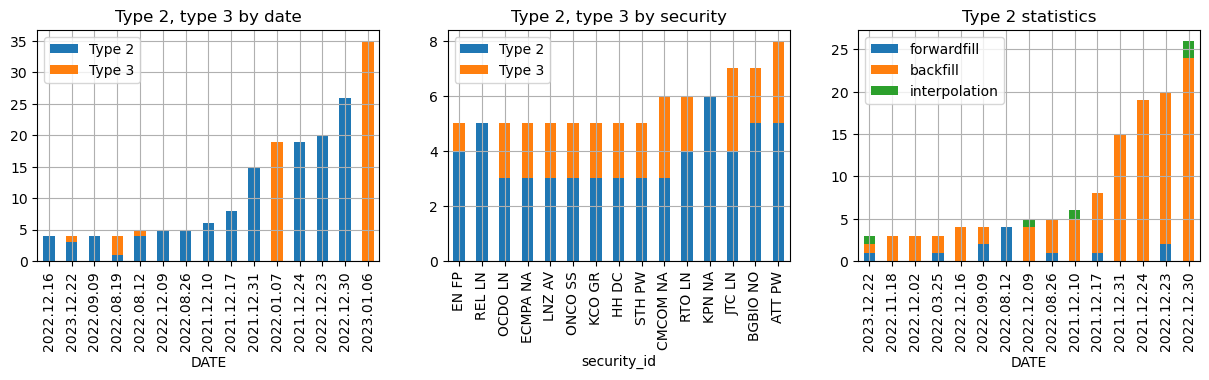

In [34]:
fig, ax = plt.subplots(1, 3, figsize=(15, 3))
a = count_date.iloc[-15:][['Type 2', 'Type 3']]
a.plot.bar(stacked = True, ax=ax[0], title = 'Type 2, type 3 by date')

b = count_sec.iloc[-15:][['Type 2', 'Type 3']]
b.plot.bar(stacked = True, ax = ax[1], title = 'Type 2, type 3 by security')

c = count_type2.iloc[-15:][['forwardfill', 'backfill', 'interpolation']]
c.plot.bar(stacked = True, ax=ax[2], title = 'Type 2 statistics')
[ax[i].grid() for i in range(len(ax))]
plt.show()
df_type2 = df_type2.drop(columns = ['forwardfill', 'backfill', 'interpolation'])

##### Type 2; KC NA, BBG available

In [35]:
print("On a l'impression que Bloomberg utilise forward fill (> 1 semaine)")
df_type2[df_type2['BBG weekly']==df_type2['prev. value daily']]

On a l'impression que Bloomberg utilise forward fill (> 1 semaine)


DATE  security_id  BBG weekly  resample KC  diff  prev. value daily prev. daily date prev. weekday  nb days ffill  next value daily next daily date  nb days bfill
5    2022.08.12           31       3.302          NaN   NaN              3.302       2022-08-05        Friday            7.0             3.302      2022-08-15           10.0
7    2023.08.18           31       3.636          NaN   NaN              3.636       2023-08-11        Friday            7.0             3.636      2023-08-28           17.0
10   2022.09.09           89      20.560          NaN   NaN             20.560       2022-09-01      Thursday            8.0            20.560      2022-09-12           11.0
13   2022.08.12          286       1.826          NaN   NaN              1.826       2022-08-04      Thursday            8.0             1.826      2022-08-15           11.0
33   2023.08.11         8087       1.212          NaN   NaN              1.212       2023-08-04        Friday            7.0             1.212      2023-08-14           10.0
..          ...          ...         ...          ...   ...                ...              ...           ...            ...               ...             ...            ...
199  2023.02.24      2783174       1.013          NaN   NaN              1.013       2023-02-14       Tuesday           10.0             1.025      2023-02-27           13.0
217  2021.12.17      2907194       0.056          NaN   NaN              0.056       2021-12-10        Friday            7.0             0.056      2022-01-03           24.0
218  2022.04.22      2907194       0.074          NaN   NaN              0.074       2022-04-11        Monday           11.0             0.074      2022-05-02           21.0
219  2024.01.19      2907194       0.130          NaN   NaN              0.130       2024-01-08        Monday           11.0             0.131      2024-01-29           21.0
244  2022.07.15     10173378       1.190          NaN   NaN              1.190       2022-07-08        Friday            7.0             1.190      2022-08-08           31.0

[26 rows x 12 columns]

In [36]:
print("On a l'impression que Bloomberg utilise backfill")
df_type22 = df_type2[(df_type2['BBG weekly']==df_type2['next value daily']) & (df_type2['BBG weekly']!=df_type2['prev. value daily'])]
df_type22

On a l'impression que Bloomberg utilise backfill


DATE  security_id  BBG weekly  resample KC  diff  prev. value daily prev. daily date prev. weekday  nb days ffill  next value daily next daily date  nb days bfill
0    2021.12.17           25       5.058          NaN   NaN              4.803       2021-12-10        Friday            7.0             5.058      2022-01-03           24.0
1    2022.08.26           25       5.307          NaN   NaN              5.273       2022-08-15        Monday           11.0             5.307      2022-09-12           28.0
2    2022.09.02           25       5.307          NaN   NaN              5.273       2022-08-15        Monday           18.0             5.307      2022-09-12           28.0
4    2021.12.31           31       3.342          NaN   NaN              2.773       2021-12-24        Friday            7.0             3.342      2022-01-03           10.0
9    2021.12.31           89      14.125          NaN   NaN             20.038       2021-12-21       Tuesday           10.0            14.125      2022-01-03           13.0
..          ...          ...         ...          ...   ...                ...              ...           ...            ...               ...             ...            ...
239  2022.12.23      3018908       3.505          NaN   NaN              0.695       2022-12-13       Tuesday           10.0             3.505      2023-01-02           20.0
241  2021.12.24      3031213       0.583          NaN   NaN              0.545       2021-12-14       Tuesday           10.0             0.583      2022-01-03           20.0
242  2022.12.30     10172537       3.323          NaN   NaN              3.077       2022-12-22      Thursday            8.0             3.323      2023-01-02           11.0
246  2022.11.18     10173378       1.275          NaN   NaN              1.133       2022-11-11        Friday            7.0             1.275      2022-11-21           10.0
247  2022.12.23     10173378       1.383          NaN   NaN              1.328       2022-12-13       Tuesday           10.0             1.383      2023-01-02           20.0

[136 rows x 12 columns]

In [37]:
print("Pour les backfill, souvent BBG utilise la valeur de la prochaine année fiscale pour filler la fin le l'année précécente, on voit bien le saut (pct_jump)")
df_bffill = df_type22[(df_type22['next daily date'].isin(['2024-01-01', '2023-01-02', '2022-01-03'])) & (df_type22.DATE.str[5:7]=='12')]
df_bffill['pct_jump'] = ((df_bffill['BBG weekly'] - df_bffill['prev. value daily'])/df_bffill['prev. value daily']*100).round(2)
df_bffill.sort_values(by = ['security_id', 'next daily date'])

Pour les backfill, souvent BBG utilise la valeur de la prochaine année fiscale pour filler la fin le l'année précécente, on voit bien le saut (pct_jump)


DATE  security_id  BBG weekly  resample KC  diff  prev. value daily prev. daily date prev. weekday  nb days ffill  next value daily next daily date  nb days bfill  pct_jump
0    2021.12.17           25       5.058          NaN   NaN              4.803       2021-12-10        Friday            7.0             5.058      2022-01-03           24.0      5.31
4    2021.12.31           31       3.342          NaN   NaN              2.773       2021-12-24        Friday            7.0             3.342      2022-01-03           10.0     20.52
9    2021.12.31           89      14.125          NaN   NaN             20.038       2021-12-21       Tuesday           10.0            14.125      2022-01-03           13.0    -29.51
11   2022.12.30          210      37.238          NaN   NaN             33.741       2022-12-23        Friday            7.0            37.238      2023-01-02           10.0     10.36
12   2021.12.31          286       0.498          NaN   NaN              0.512       2021-12-24        Friday            7.0             0.498      2022-01-03           10.0     -2.73
..          ...          ...         ...          ...   ...                ...              ...           ...            ...               ...             ...            ...       ...
237  2021.12.17      3018908       2.600          NaN   NaN              2.420       2021-12-09      Thursday            8.0             2.600      2022-01-03           25.0      7.44
239  2022.12.23      3018908       3.505          NaN   NaN              0.695       2022-12-13       Tuesday           10.0             3.505      2023-01-02           20.0    404.32
241  2021.12.24      3031213       0.583          NaN   NaN              0.545       2021-12-14       Tuesday           10.0             0.583      2022-01-03           20.0      6.97
242  2022.12.30     10172537       3.323          NaN   NaN              3.077       2022-12-22      Thursday            8.0             3.323      2023-01-02           11.0      7.99
247  2022.12.23     10173378       1.383          NaN   NaN              1.328       2022-12-13       Tuesday           10.0             1.383      2023-01-02           20.0      4.14

[96 rows x 13 columns]

In [29]:
print("On a l'impression que Bloomberg utilise interpolation par les valeur avant et après. Il y a bcp de valeur de fin d'année")
df_type2[(df_type2['BBG weekly']!=df_type2['next value daily'])& (df_type2['BBG weekly']!=df_type2['prev. value daily'])]

On a l'impression que Bloomberg utilise interpolation par les valeur avant et après. Il y a bcp de valeur de fin d'année


DATE  security_id  BBG weekly  resample KC  diff  prev. value daily prev. daily date prev. weekday  nb days ffill  next value daily next daily date  nb days bfill
6    2022.10.28           31       3.211          NaN   NaN              3.214       2022-10-20      Thursday            8.0             3.193      2022-10-31           11.0
22   2022.12.30         6254       1.081          NaN   NaN              0.673       2022-12-20       Tuesday           10.0             1.073      2023-01-02           13.0
40   2023.12.29        11701       0.207          NaN   NaN              0.206       2023-12-21      Thursday            8.0             0.219      2024-01-01           11.0
73   2023.12.22        19072       0.891          NaN   NaN              0.885       2023-12-12       Tuesday           10.0             1.549      2024-01-01           20.0
128  2022.12.30       395770       4.436          NaN   NaN              5.454       2022-12-19        Monday           11.0             4.438      2023-01-02           14.0
161  2021.12.10      2732114       0.338          NaN   NaN              0.198       2021-12-03        Friday            7.0             0.306      2022-01-03           31.0
194  2022.12.09      2765679      -3.628          NaN   NaN             -3.731       2022-11-28        Monday           11.0            -4.124      2023-01-02           35.0
210  2023.12.08      2833331      10.860          NaN   NaN             10.020       2023-12-01        Friday            7.0            10.792      2023-12-11           10.0

##### Type 3

In [30]:
df_type3

DATE  security_id  BBG weekly  resample KC  diff  prev. value daily prev. daily date prev. weekday  nb days ffill  next value daily next daily date  nb days bfill
3    2022.09.16           25         NaN        5.307   NaN              5.307       2022-09-12        Monday            4.0             5.313      2022-09-19            7.0
8    2023.09.01           31         NaN        3.636   NaN              3.636       2023-08-28        Monday            4.0             3.636      2023-09-07           10.0
14   2022.08.19          286         NaN        1.826   NaN              1.826       2022-08-15        Monday            4.0             1.826      2022-08-23            8.0
19   2023.01.06          436         NaN        0.960   NaN              0.960       2023-01-02        Monday            4.0             0.960      2023-02-02           31.0
28   2023.01.06         6672         NaN        4.655   NaN              4.655       2023-01-02        Monday            4.0             4.693      2023-01-16           14.0
..          ...          ...         ...          ...   ...                ...              ...           ...            ...               ...             ...            ...
238  2022.01.07      3018908         NaN        2.600   NaN              2.600       2022-01-03        Monday            4.0             2.550      2022-03-16           72.0
240  2023.01.06      3018908         NaN        3.505   NaN              3.505       2023-01-02        Monday            4.0             2.503      2023-03-16           73.0
243  2023.01.06     10172537         NaN        3.323   NaN              3.323       2023-01-02        Monday            4.0             3.463      2023-02-03           32.0
245  2022.08.12     10173378         NaN        1.190   NaN              1.190       2022-08-08        Monday            4.0             1.360      2022-08-15            7.0
248  2023.01.06     10173378         NaN        1.383   NaN              1.383       2023-01-02        Monday            4.0             1.398      2023-02-17           46.0

[79 rows x 12 columns]

In [17]:
df_type3.DATE.value_counts()
print(df_type3['prev. weekday'].unique())
df_type3.DATE.value_counts().to_frame().T

['Monday']


DATE   2023.01.06  2022.01.07  2022.08.19  2023.04.07  2023.12.15  2023.12.29  2023.01.13  2022.06.24  2023.12.22  2022.09.30  2022.01.28  2023.02.10  2022.09.16  2023.06.23  2023.08.04  2023.09.01  2022.04.01  2023.05.12  2022.07.08  2022.08.12
count          35          19           3           3           2           2           2           1           1           1           1           1           1           1           1           1           1           1           1           1

# End of notebook

## Draft

In [ ]:
df_type2[df_type2['BBG weekly']==df_type2['prev. value daily']]

In [ ]:
df_daily_ts[25].dropna()

In [ ]:
df_diff_fri

In [ ]:
df_type2

#### stocks dont 1GY sont dispo le 1er janvier, début l'année fiscale, même si un weekend
Tous les stocks dont l'année fiscale commence en janvier ont des données 1GY

In [ ]:
df_fy_23 = df_daily_db[(~df_daily_db.security_id.isin(sec_anom)) & df_daily_db.DATE.isin(pd.date_range('20221228', '20230105'))]
df_fy_23 = df_fy_23.set_index(['security_id', 'attribute_id', 'DATE']).value.unstack()

df_fy_22 = df_daily_db[(~df_daily_db.security_id.isin(sec_anom)) & df_daily_db.DATE.isin(pd.date_range('20211228', '20220105'))]
df_fy_22 = df_fy_22.set_index(['security_id', 'attribute_id', 'DATE']).value.unstack()

In [ ]:
df_fy_23[df_fy_23['2023.01.01'].isna()]

In [ ]:
df_fy_22[df_fy_22['2022-01-01'].isna()]

#### Si les données de 1GY début l'AF est remplies par 2GY de l'année précédente: NON

In [ ]:
df = pd.concat((df_1gy_daily_ts.loc['2023-01-01'].to_frame('1GY_20230101'),
                df_2gy_daily_ts.loc['2022-01-01'].to_frame('2GY_20220101')), axis = 1)
df = df[~df.index.isin(sec_anom)]
df['is_filled'] = df['1GY_20230101'] == df['2GY_20220101']
df[df.is_filled]

In [ ]:
df_type2